In [43]:
import numpy as np
import pandas as pd
import sys
sys.path.append("src")
import VirtualInstrument
import ParamGenerator as SG
import json
import TreeHierarchy as TH
from scipy.stats.qmc import LatinHypercube
import ArrayTuner
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Radnom sampling function
For every morphology in the dataset we need a function that can generate a set of random examples, random draws of the structural parameters.  This portion of the code certainly contains a level of techinical debt and is ripe for improvement when genrealizing the model to new tasks. Each morphology is assigned one function that merely takes the number of desired samples as an argument. All the mins and maxes as well as the sampling type (uniform vs logarithmic are the most common choices) are baked into these functions. 

In [2]:
def random_MLS(count):
    n_shells = np.random.randint(2, 30, count)
    radii = np.random.uniform(10, 2500, count)
    shell_thick = np.random.uniform(10,300,count)
    water_thick = np.random.uniform(10,50,count)
    sld= np.random.uniform(0.5, 5.0, count)
    background = np.random.uniform(-3.5,-1,count)
    sld_solvent = np.random.uniform(4.4,8.4,count)
    scale = np.random.uniform(0.1, 1.0, count)
    return_list = [{"n_shells": n_shells[i],
                    "radius": radii[i],
                    "thick_shell": shell_thick[i],
                    "thick_solvent": water_thick[i],
                    "background": 10**background[i],
                    "sld_solvent": sld_solvent[i],
                    "scale": scale[i],
                    "sld": sld[i]} for i in range(count)]
    return(return_list)

In [3]:
def random_cylinder(count):
    radii = np.random.uniform(10, 2500, count)
    length = np.random.uniform(50, 250, count)
    sld = np.random.uniform(0.5, 5.0, count)
    background = np.random.uniform(-3.5,-1,count)
    sld_solvent = np.random.uniform(4.4,8.4,count)
    scale = np.random.uniform(0.1, 1.0, count)
    return_list = [{"radius":radii[i],
                    "length":2*radii[i]+length[i],
                    "background": 10**background[i],
                    "sld_solvent": sld_solvent[i],
                    "scale": scale[i],
                    "sld":sld[i]} for i in range(count)]
    return(return_list)

In [4]:
def random_disk(count):
    radii = np.random.uniform(10.0, 2500.0, count)
    length = np.random.uniform(10.0, 100.0, count)
    background = np.random.uniform(-3.5,-1,count)
    sld_solvent = np.random.uniform(4.4,8.4,count)
    scale = np.random.uniform(0.1, 1.0, count)
    sld = np.random.uniform(0.5, 5.0, count)
    return_list = [{"radius":length[i]+radii[i],
                    "length":length[i],
                    "background": 10**background[i],
                    "sld_solvent": sld_solvent[i],
                    "scale": scale[i],
                    "sld":sld[i]} for i in range(count)]
    return(return_list)

In [121]:
def random_cs_disk(count):
    radii = np.random.uniform(10.0, 2500.0, count)
    length = np.random.uniform(10.0, 100.0, count)
    shell_thick = np.random.uniform(25,100,count)
    background = np.random.uniform(-3.5,-1,count)
    sld_solvent = np.random.uniform(4.4,8.4,count)
    scale = np.random.uniform(0.1, 1.0, count)
    sld = np.random.uniform(0.5, 5.0, count)
    sld_shell = np.random.uniform(0.,4.,count)
    return_list = [{"radius":length[i]+radii[i],
                    "length":length[i],
                    "background": 10**background[i],
                    "sld_solvent": sld_solvent[i],
                    "sld_shell": sld_shell[i],
                    "scale": scale[i],
                    "sld_core":sld[i]} for i in range(count)]
    return(return_list)

In [109]:
def random_cs_sphere(count):
    radii = np.random.uniform(10, 2500, count)
    shell_thick = np.random.uniform(25,100,count)
    background = np.random.uniform(-3.5,-1,count)
    sld_solvent = np.random.uniform(4.4,8.4,count)
    scale = np.random.uniform(0.1, 1.0, count)
    sld= np.random.uniform(0.5, 5.0, count)
    sld_shell = np.random.uniform(0.,4.,count)
    return_list = [{"radius": radii[i],
                    "thickness": shell_thick[i],
                    "background": 10**background[i],
                    "sld_solvent": sld_solvent[i],
                    "sld_shell": sld_shell[i],
                    "scale": scale[i],
                    "sld_core": sld[i]} for i in range(count)]
    return(return_list)

In [6]:
def random_wormlike_micelle(count):
    length = np.random.uniform(3500, 3500, count)
    radii = np.random.uniform(30, 60, count)
    background = np.random.uniform(-3.5, -1, count)
    background = np.random.uniform(0.001, 0.001, count)
    kuhn_length = np.random.uniform(50, 50, count)
    pds = np.random.uniform(0.3, 0.5, count)
    axis_ratio = np.random.uniform(1.0, 2.0, count)
    return_list = [{"radius":radii[i],
                    "length":length[i],
                    "background":10**background[i],
                    "kuhn_length":kuhn_length[i],
                    "radius_pd": pds[i],
                    "radius_pd_type": "schulz",
                    "radius_pd_n": 8.,
                    "radius_pd_nsigma": 30,
                    "axis_ratio":axis_ratio[i]} for i in range(count)]
    return(return_list)


In [7]:
def map_pdict(indict, default_dict):
    #params_to_map = ["n_shells", "radius", "thick_shell", "thick_solvent", "sld"]
    params_to_map = indict.keys()
    defaults = {key: default_dict[key] for key in default_dict.keys() if key not in indict.keys()}
    outdict = {key:indict[key] for key in params_to_map} | defaults
    return(outdict)

In [8]:
def sample_SAS_curves(count):
   all_curves = []
   all_labels =[]
   all_params = {}
   for t in targets.keys():
      t_list, n_list = None, None
      model_name = model_names[t] if t in model_names.keys() else t
      calcs, sds = vi.construct_calculators(model_name)
      t_list, n_list = generators[t].sample(count)
      all_params[t] = unwrap_params(t_list)
      param_df = tabularize_params(n_list)
      param_df.to_csv("parameters_%s.csv"%(t))
      curves = [vi.generate(model_name, kw, calcs, sds)[0] for kw in n_list]
      all_curves += curves
      all_labels += [t for i in range(count)]
   param_lists = concat_params(all_labels, all_params)
   q = all_curves[0].index
   all_curves = np.array(all_curves)
   all_valid = filter_nan(all_curves)
   all_curves = all_curves[all_valid]
   all_labels = np.array(all_labels)
   all_labels = all_labels[all_valid]
   for p in param_lists.keys():
       param_lists[p] = param_lists[p][all_valid]
   return(all_curves, all_labels, param_lists)


In [9]:
# These are some dictionaries of the various defaults for parameters we aren't randomly sampling.

general_default_dict = {"scale":1,
                 "background": 0.001,
                 "sld_solvent": 6.4,
                 "radius_pd":.3,
                 "radius_pd_n":40,
                 "radius_pd_type":"schulz"}
cylinder_default_dict = {"scale":1,
                 "background": 0.001,
                 "sld_solvent": 6.4,
                 "length_pd":.3,
                 "length_pd_n":40,
                 "length_pd_type":"schulz"}
cs_sphere_default_dict = {"scale":1,
                 "background": 0.001,
                 "sld_solvent": 6.4,
                 "sld_core": 6.4,
                 "radius_pd":.3,
                 "radius_pd_n":40,
                 "radius_pd_type":"schulz"}

Below are a few helper functions to format the data into an xarray as well as filter out any NaN etc.

In [94]:
def filter_nan(arr):
    return(np.where(np.all(np.logical_not(np.isnan(arr)), axis=1))[0])

def tabularize_params(param_table):
    keys = param_table[0].keys()
    lim = len(param_table)
    outdf = {k:np.array([p[k] for p in param_table]) for k in keys}
    return(pd.DataFrame(outdf))

def make_map_function(reference_dict):
    def newfunc(indict):
        return(map_pdict(indict, reference_dict))
    return(newfunc)

def concat_params(labels, params):
    unique_params = []
    ptypes = {}
    for morphology in params.keys():
        for param in params[morphology].keys():
            if param not in unique_params:
                unique_params += [param]
                ptypes[param] = type(params[morphology][param][0])
    all_params = {param: np.zeros(len(labels), dtype = ptypes[param]) for param in unique_params}
    for morphology in params.keys():
        #inds = np.where(labels == morphology)[0]
        inds = np.where(np.array([lab == morphology for lab in labels]))[0]
        for param in unique_params:
            if param in params[morphology].keys():
                all_params[param][inds] = params[morphology][param]
            else:
                print(inds)
                all_params[param][inds] = np.nan * np.ones(inds.shape[0])
    return(all_params)

def unwrap_params(params):
    unique_params = params[0].keys()
    params = {p: np.array([para[p] for para in params]) for p in unique_params}
    return(params)

def bg_norm(curves, bg = 0.00001):
    new_curves = np.zeros(curves.shape)
    for i in range(curves.shape[0]):
        new_curves[i,:] = curves[i,:] - np.min(curves[i,:])+bg
    return(new_curves)

def make_xarray(curves, params, labels, q, test_curves = None, test_params = None, test_labels = None):
    new_array = xr.Dataset()
    inds = np.arange(labels.shape[0])
    test_inds = np.arange(test_labels.shape[0])
    new_array['sample'] = inds
    new_array['q'] = q
    new_array['SAS_curves'] = (['sample', 'q'], curves)
    new_array['labels'] = (['sample'], labels)
    for p in params.keys():
        new_array[p] = (['sample'], params[p])
    if test_curves is not None and test_params is not None and test_labels is not None:
        new_array['test_sample'] = test_inds
        new_array['test_curves'] = (['test_sample', 'q'], test_curves)
        new_array['test_labels'] = (['test_sample'], test_labels)
        for p in test_params.keys():
            new_array["test_%s"%(p)] = (['test_sample'], params[p])
    return(new_array)


# Defining constants of the generation

In [123]:
   count = 1000
   targets = {'flexible_cylinder_elliptical': random_wormlike_micelle,
              'core_shell_sphere': random_cs_sphere,
              'multilayer_vesicle': random_MLS,
              'disk': random_disk,
             'core_shell_disk': random_cs_disk}
   default_map = {'flexible_cylinder_elliptical': general_default_dict,
              'core_shell_sphere': cs_sphere_default_dict,
              'multilayer_vesicle': general_default_dict,
              'disk': cylinder_default_dict,
              'core_shell_disk': cs_sphere_default_dict}

   model_names = {'disk':'cylinder', "core_shell_disk": "core_shell_cylinder"}
   parameterizers = {t: make_map_function( default_map[t]) for t in targets.keys()}

   generators = {t:SG.ParamGenerator(targets[t], parameterizers[t]) for t in targets.keys()}
   
   reference_files = ["data/bg_sub/S_r30407_0p1_Bicelles_500mM_NaCl.csv"]
   vi = VirtualInstrument.VirtualInstrument()
   vi.add_references(reference_files)


Index(['q', 'I', 'dI', 'dq'], dtype='object')


/home/grahamroberts/qyangwork/exsas/SASML2.0/src/VirtualInstrument.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fn, delim_whitespace=True)


In [12]:
import os
print(os.listdir("data/bg_sub"))

['S_r30369_10pBicelle_0mM_NaCl.csv', 'S_r30389_1p0_Bicelles_0mM_NaCl.csv', 'S_r30371_10pBicelles_1mM_NaCl.csv', 'S_r30387_5p0_Bicelles_500mM_NaCl.csv', 'S_r30403_0p1_Bicelles_10mM_NaCl.csv', 'S_r30375_10pBicelle_100mM_NaCl.csv', 'S_r30385_5p0_Bicelles_100mM_NaCl.csv', 'S_r30381_5p0_Bicelles_1mM_NaCl.csv', 'S_r30401_0p1_Bicelles_1mM_NaCl.csv', 'S_r30397_1p0_Bicelles_500mM_NaCl.csv', 'S_r30395_1p0_Bicelles_100mM_NaCl.csv', 'S_r30373_10pBicelle_10mM_NaCl.csv', 'S_r30393_1p0_Bicelles_10mM_NaCl.csv', 'S_r30399_0p1_Bicelles_0mM_NaCl.csv', 'S_r30377_10pBicelle_500mM_NaCl.csv', 'S_r30379_5p0_Bicelles_0mM_NaCl.csv', 'S_r30383_5p0_Bicelles_10mM_NaCl.csv', 'S_r30391_1p0_Bicelles_1mM_NaCl.csv', 'S_r30405_0p1_Bicelles_100mM_NaCl.csv', 'S_r30407_0p1_Bicelles_500mM_NaCl.csv']


In [13]:
os.getcwd()

'/home/grahamroberts/qyangwork/exsas/SASML2.0'

In [124]:
train_curves, train_labels, train_params = sample_SAS_curves(count)
train_X = np.log10(bg_norm(train_curves**10))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

/tmp/ipykernel_310032/1870282860.py:32: RuntimeWarning: invalid value encountered in cast
  all_params[param][inds] = np.nan * np.ones(inds.shape[0])


In [125]:
test_curves, test_labels, test_params = sample_SAS_curves(count)
test_X = np.log10(bg_norm(test_curves**10))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

/tmp/ipykernel_310032/1870282860.py:32: RuntimeWarning: invalid value encountered in cast
  all_params[param][inds] = np.nan * np.ones(inds.shape[0])


#Tuning the classifier


In [16]:
def scale_range(val, bounds):
    return(val * (bounds[1]-bounds[0]) + bounds[0])

def scale_binary(val, bounds):
    return(bounds[0] if val < 0.5 else bounds[1])

def ident(x):
    return(x)

param_list = ["C", "gamma", "coef0"]
pbounds = {"C": (-3,3),
           "gamma": ("auto", "scale"),
           "coef0": (0,1)}
select_map = {"C": scale_range,
              "gamma": scale_binary,
              "coef0": scale_binary}
wrapper_map = {"C": lambda x: 10**x,
               "gamma": ident,
               "coef0": ident}


In [17]:
def map_rbf_SVC_sample(arr):
    return({param_list[i]: wrapper_map[param_list[i]](select_map[param_list[i]](arr[i], pbounds[param_list[i]])) for (i,p) in enumerate(arr)} | {"type": "SVC", "kernel": {"type": "rbf"}})


In [18]:
def LHS_params(params, map_func, count=20):
    num_params = len(params)
    lh = LatinHypercube(num_params)
    outarr = [map_func(v) for v in lh.random(count)]
    return(outarr)


In [19]:
def load_all_data(args):
    X = np.log10(np.loadtxt(args.X, delimiter=','))
    y = np.loadtxt(args.y, delimiter=',', dtype = str)
    test_X = np.log10(np.loadtxt(args.test_X, delimiter=','))
    test_y = np.loadtxt(args.test_y, delimiter=',', dtype = str)
    return(X, y, test_X, test_y)


In [20]:
def select_data(X, y, C1, C2):
    relevant_inds = np.where(np.logical_or(np.isin(y, C1), np.isin(y, C2)))[0]
    temp_X = X[relevant_inds]
    #temp_y = y[relevan_inds]
    temp_y = np.zeros(temp_X.shape[0])
    temp_y[np.where(np.isin(y[relevant_inds], C2))[0]] = 1
    return(temp_X, temp_y)


In [21]:
def parse_json(fn):
    infile = open(fn, "r")
    indat = infile.read()
    j_string = json.loads(indat)
    return(j_string)


In [22]:
def make_tree(fn):
    jdict = parse_json(fn)
    tree = TH.TreeHierarchy()
    #tree.from_json(jdict)
    tree.structure_from_json(jdict)
    return(tree)


In [23]:
def inverse_KFold(X, y, classifier, n_splits=5):
    skf = StratifiedKFold(n_splits = n_splits, shuffle=True)
    sum_perf = 0
    for val_inds, train_inds in skf.split(X,y):
        classifier.fit(X[train_inds], y[train_inds])
        sum_perf += accuracy_score(y[val_inds], classifier.predict(X[val_inds]))
    return(sum_perf / n_splits)


In [24]:
def create_svc(p):
    svc = SVC(C = p["C"],
              gamma = p["gamma"],
              coef0 = p["coef0"],
              kernel = p["kernel"]["type"],
              degree = p["kernel"]["degree"] if p["kernel"]["type"] == "poly" else 0)
    return(svc)


In [77]:

def tune_tree(tree, X, y):
    if not getattr(tree, 'terminal', False):
       tX, ty = select_data(X, y, tree.classA, tree.classB)
       params = LHS_params(param_list, map_rbf_SVC_sample, count=20)
       tuner = ArrayTuner.ArrayTuner(params)
       for p in tuner:
           tuner.report([p], inverse_KFold(tX, ty, create_svc(p)))
       setattr(tree, "entity", create_svc(tuner.best[0]))
       tune_tree(tree.left, X, y)
       tune_tree(tree.right, X, y)
    return

In [61]:
def tune_all_decisions(tf, X, y):
    #infile = open(args.structure, 'r')
    tree = make_tree(tf)
    print(type(tree))
    tune_tree(tree, X, y)
    #tree.to_json(args.output)
    return(tree)

In [129]:
treefile = "src/raw_tree2.json"
tree = tune_all_decisions(treefile, train_X, train_labels)
tree.fit(train_X, train_labels)

<class 'TreeHierarchy.TreeHierarchy'>


In [130]:
preds = tree.predict(test_X)


In [131]:
from sklearn.metrics import classification_report as CR
print(CR(test_labels, preds))

                              precision    recall  f1-score   support

             core_shell_disk       0.97      0.97      0.97      1000
           core_shell_sphere       0.99      0.94      0.97      1000
                        disk       0.93      1.00      0.96      1000
flexible_cylinder_elliptical       1.00      1.00      1.00      1000
          multilayer_vesicle       1.00      0.98      0.99      1000

                    accuracy                           0.98      5000
                   macro avg       0.98      0.98      0.98      5000
                weighted avg       0.98      0.98      0.98      5000



In [132]:
files = os.listdir('data/bg_sub')
ecurves = np.zeros((len(files),train_curves.shape[1]))
for (i,file) in enumerate(files):
    indf = pd.DataFrame(pd.read_csv("data/bg_sub/%s"%(file), sep='\s+'))
    ecurves[i,:] = np.array(indf.loc[:,"I"])
eX = np.log10(bg_norm(ecurves**100))
    

In [133]:
rpreds = tree.predict(ecurves)

In [134]:
rpreds

array([np.str_('core_shell_disk'), np.str_('multilayer_vesicle'),
       np.str_('core_shell_disk'), np.str_('disk'), np.str_('disk'),
       np.str_('core_shell_disk'), np.str_('multilayer_vesicle'),
       np.str_('multilayer_vesicle'), np.str_('disk'),
       np.str_('multilayer_vesicle'), np.str_('multilayer_vesicle'),
       np.str_('core_shell_disk'), np.str_('multilayer_vesicle'),
       np.str_('disk'), np.str_('core_shell_disk'),
       np.str_('core_shell_disk'), np.str_('multilayer_vesicle'),
       np.str_('multilayer_vesicle'), np.str_('multilayer_vesicle'),
       np.str_('multilayer_vesicle')], dtype=object)

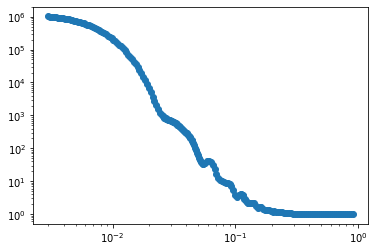

In [115]:
from matplotlib import pyplot as plt
plt.xscale('log')
plt.yscale('log')
plt.scatter(indf.loc[:,'q'], train_curves[0])


In [93]:
train_X[0,:]

array([0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174502,
       0.00174502, 0.00174502, 0.00174502, 0.00174502, 0.00174

In [136]:
for i in range(eX.shape[0]):
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(indf.loc[:,'q'], ecurves[i,:])
    plt.title("%s %s"%(files[i].replace(".csv",""), rpreds[i]))
    plt.xlabel(r'Q, ($\AA^{-1}$')
    plt.ylabel(r'I(Q) (cm$^{-1}$)')
    plt.savefig("resplots/%s"%(files[i].replace(".csv", ".png")))
    plt.clf()

<Figure size 432x288 with 0 Axes>